In [92]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

df = pd.read_csv("pulsar_stars.csv")

In [93]:
# Lad os starte med at udforske data lidt ved at udforske kommandoerne shape, head og columns. 
print(df.shape)
print(df.head())
df.columns

# Ofte starter kolonnenavne med mellemrum, disse kan fjernes ved column.str.strip().
df.columns.str.strip()

# Faktisk vil vi hellere bruge forkortelser da kolonnenavnene er ret lange.  
# Ændr kolonnenavnene til ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis',
# 'DM-SNR Skewness', 'target_class']
new_column_names = ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']
df.columns = new_column_names

(17898, 9)
    Mean of the integrated profile  \
0                       140.562500   
1                       102.507812   
2                       103.015625   
3                       136.750000   
4                        88.726562   

    Standard deviation of the integrated profile  \
0                                      55.683782   
1                                      58.882430   
2                                      39.341649   
3                                      57.178449   
4                                      40.672225   

    Excess kurtosis of the integrated profile  \
0                                   -0.234571   
1                                    0.465318   
2                                    0.323328   
3                                   -0.068415   
4                                    0.600866   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.699648                   3.199833   
1             

In [94]:
# Tjek fordelingen af target med: df['target_class'].value_counts()
df['target_class'].value_counts()

# Kan du vise fordelingen i procent?
part = 1639
whole = 17898
percentage = ((part / whole) * 100)
print(percentage)

9.157447759526203


In [95]:
# Tjek om der er felter der indeholder null (tip: summér outputtet fra isnull())
null_values = pd.isnull(df)
print(null_values)

       IP Mean  IP Sd  IP Kurtosis  IP Skewness  DM-SNR Mean  DM-SNR Sd  \
0        False  False        False        False        False      False   
1        False  False        False        False        False      False   
2        False  False        False        False        False      False   
3        False  False        False        False        False      False   
4        False  False        False        False        False      False   
...        ...    ...          ...          ...          ...        ...   
17893    False  False        False        False        False      False   
17894    False  False        False        False        False      False   
17895    False  False        False        False        False      False   
17896    False  False        False        False        False      False   
17897    False  False        False        False        False      False   

       DM-SNR Kurtosis  DM-SNR Skewness  target_class  
0                False            False    

In [96]:
true_count = null_values
print(true_count.sum())

IP Mean            0
IP Sd              0
IP Kurtosis        0
IP Skewness        0
DM-SNR Mean        0
DM-SNR Sd          0
DM-SNR Kurtosis    0
DM-SNR Skewness    0
target_class       0
dtype: int64


Text(0, 0.5, 'IP Sd')

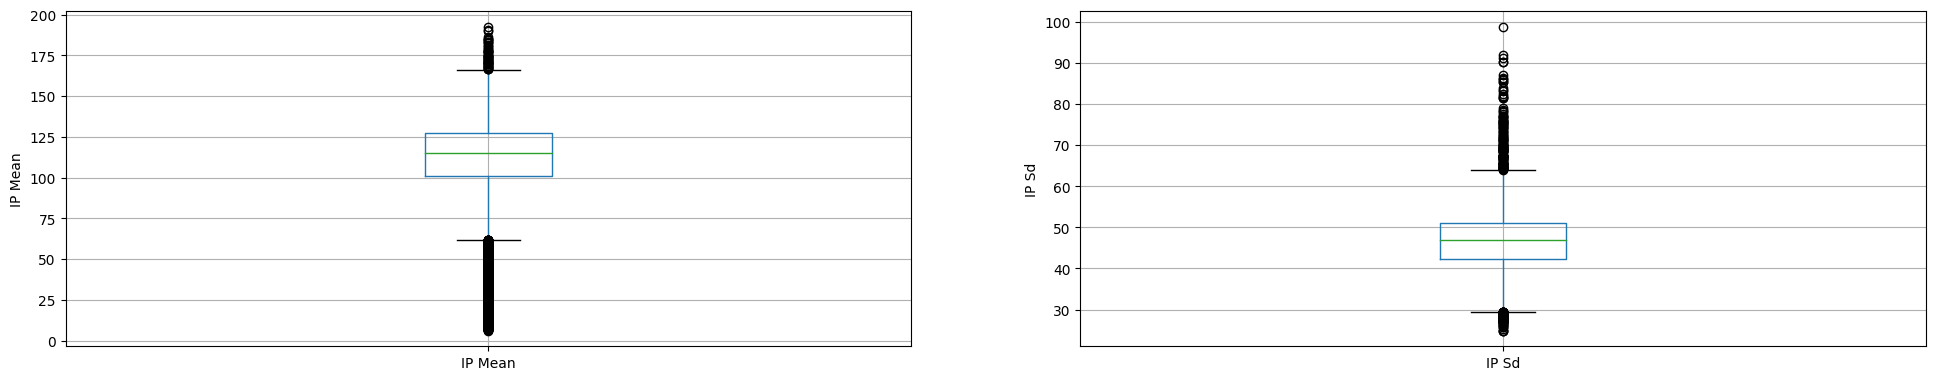

In [97]:
# I SVM kan man enten arbejde med Hard Margin eller Soft Margin3.
# Her kan det have betydning hvis variable har få eller mange outliers.
# Disse kan fx visualiseres ved at tegne et boxplot4. Nedenstående kode tegner boxplot for de to første variable: 
plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1)
fig = df.boxplot(column="IP Mean")
fig.set_title("")
fig.set_ylabel("IP Mean")

plt.subplot(4, 2, 2)
fig = df.boxplot(column="IP Sd")
fig.set_title("")
fig.set_ylabel("IP Sd")

# Tegn et boxplot for alle 8 numeriske variable

Text(0, 0.5, 'IP Skewness')

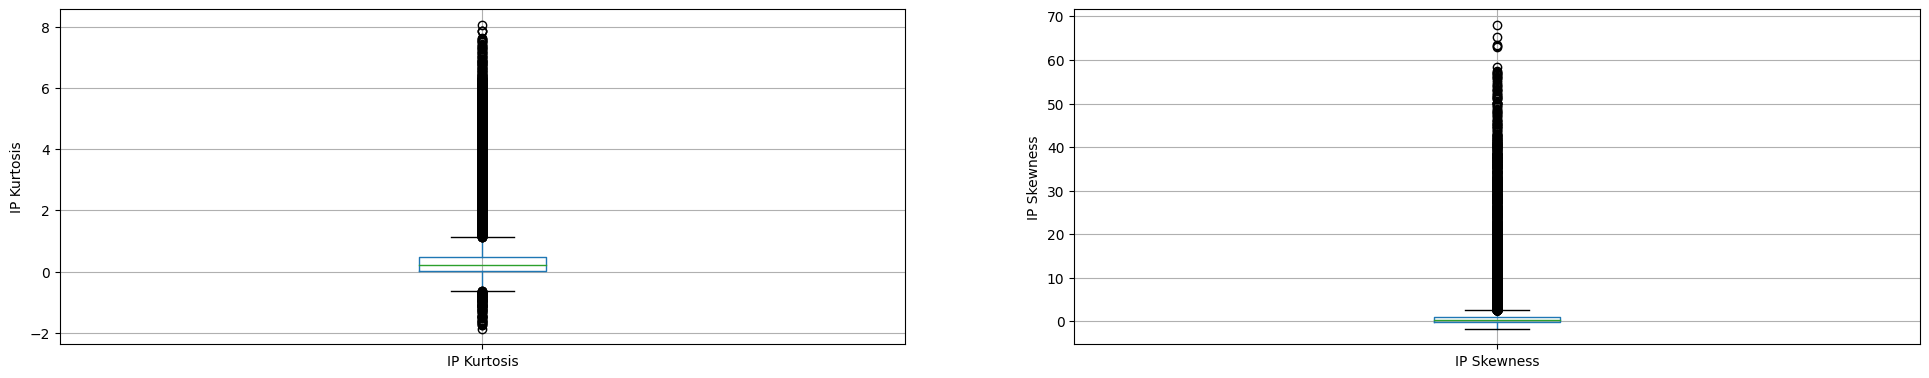

In [98]:
plt.figure(figsize=(24,20))
plt.subplot(4, 2, 1)
fig = df.boxplot(column="IP Kurtosis")
fig.set_title("")
fig.set_ylabel("IP Kurtosis")

plt.subplot(4, 2, 2)
fig = df.boxplot(column="IP Skewness")
fig.set_title("")
fig.set_ylabel("IP Skewness")

Text(0, 0.5, 'DM-SNR Sd')

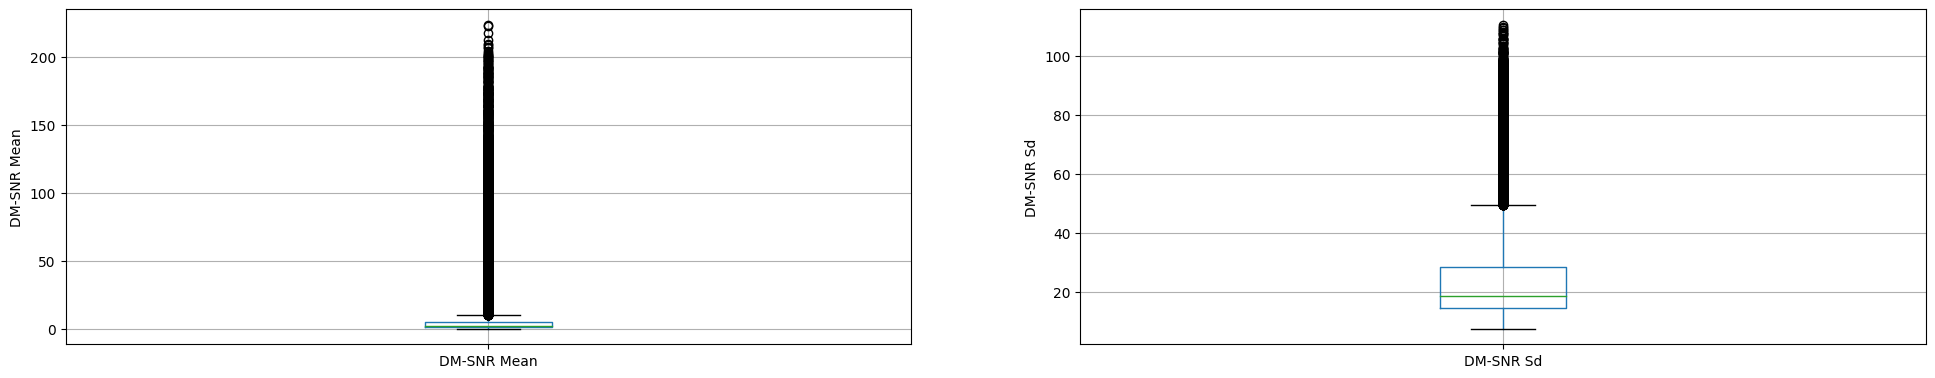

In [99]:
plt.figure(figsize=(24,20))
plt.subplot(4, 2, 1)
fig = df.boxplot(column="DM-SNR Mean")
fig.set_title("")
fig.set_ylabel("DM-SNR Mean")

plt.subplot(4, 2, 2)
fig = df.boxplot(column="DM-SNR Sd")
fig.set_title("")
fig.set_ylabel("DM-SNR Sd")

Text(0, 0.5, 'DM-SNR Skewness')

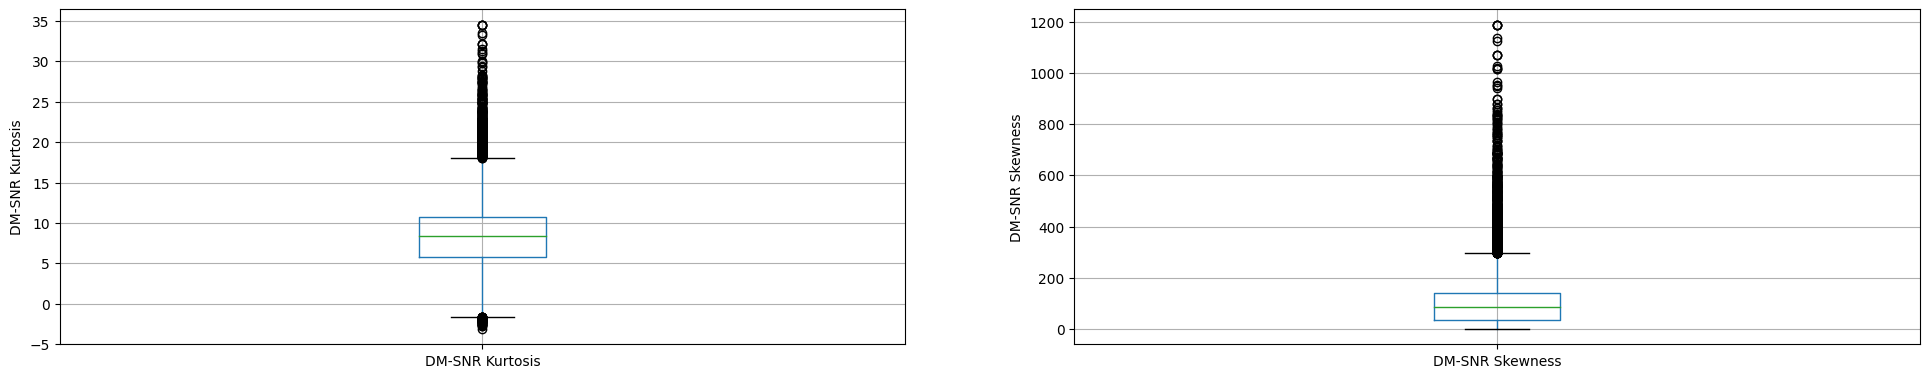

In [100]:
plt.figure(figsize=(24,20))
plt.subplot(4, 2, 1)
fig = df.boxplot(column="DM-SNR Kurtosis")
fig.set_title("")
fig.set_ylabel("DM-SNR Kurtosis")

plt.subplot(4, 2, 2)
fig = df.boxplot(column="DM-SNR Skewness")
fig.set_title("")
fig.set_ylabel("DM-SNR Skewness")

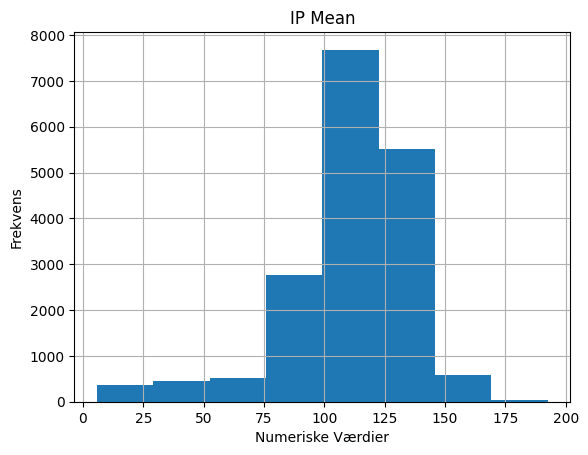

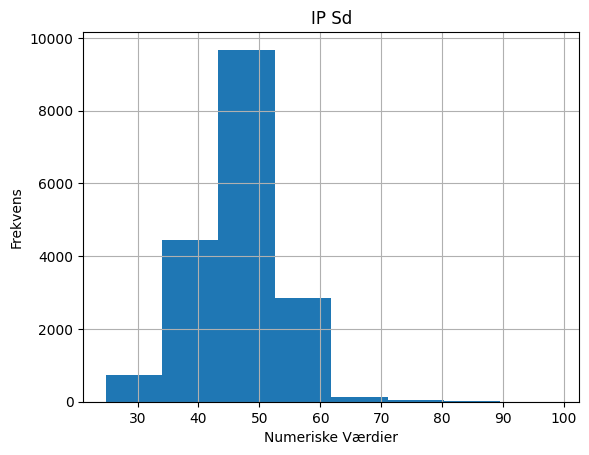

In [101]:
# Masser af outliers. Lad os se om variablene følger en normalfordeling eller om de er ”skævt” fordelt. 
# Brug hist(…) til at tegne de 8 numeriske variables fordeling udtrykt som histogrammer. Sæt label for x- og y-aksen til noget relevant. 
plt.hist(df["IP Mean"], bins=8)
plt.title("IP Mean")
plt.xlabel("Numeriske Værdier")
plt.ylabel("Frekvens")
plt.grid(True)
plt.show()

plt.hist(df["IP Sd"], bins=8)
plt.title("IP Sd")
plt.xlabel("Numeriske Værdier")
plt.ylabel("Frekvens")
plt.grid(True)
plt.show()

In [102]:
# Nu skal vi have dannet og skaleret vores data til at træne modellen.

# Lad X være data fra alle variable fra vores dataframe bortset fra variablen ”target_class” og lad y være data kun fra ” target_class”. 
X = df[['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness']].values
y = df["target_class"].values

# Dan X_train, X_test, y_train og y_test udfra X og y – lad test-delen udgøre 20%. 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [103]:
# Importer og instantier en SVC classifier og træn den med dine train data  
C = 1.0
svc = svm.SVC(kernel="linear", C=C).fit(x_train, y_train)

# Udfør prediction (hvordan er det nu man gør det?) på test data 
y_pred =svc.predict(x_test)

# Importer accuracy_score (from sklearn.metrics import accuracy_score) og beregn din models accuracy score – den skulle gerne være over 98%... 
score = accuracy_score(y_test, y_pred)
print(score)

0.979050279329609


In [104]:
# Husker du at der var mange outliers? Ved at ændre på parameteren C bestemmer vi hvor meget vi straffes for hver outlier.
# Og hvad med at anvende en anden kernel?

# Eksperimenter med forskellige værdier af C.
C = 0.5
svc = svm.SVC(kernel="linear", C=C).fit(x_train, y_train)

y_pred =svc.predict(x_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.9787709497206704


In [105]:
# Eksperimenter med forskellige kernels - fx ’linear’, ’poly’ eller ’sigmoid’. 
# Ved ’poly’ kan du angive degree (default er 3) og ved ’rbf’, ’poly’ og ’sigmoid’ kan du angive ’gamma’
# (jo højere værdi jo mere nøjagtigt forsøges det at ramme træningssættet) 
C = 1
svc_pol = svm.SVC(kernel="poly", degree=3, C=C).fit(x_train, y_train)

y_pred =svc_pol.predict(x_test)

score_pol = accuracy_score(y_test, y_pred)
print(score_pol)

0.9709497206703911


In [106]:
C = 1.0

rbf_svc = svm.SVC(kernel="rbf", gamma=0.7, C=C).fit(x_train, y_train)

y_pred =rbf_svc.predict(x_test)

score_rbf = accuracy_score(y_test, y_pred)
print(score_rbf)

KeyboardInterrupt: 

In [ ]:
C = 2.0

sig_svc = svm.SVC(kernel="sigmoid", gamma=0.7, C=C).fit(x_train, y_train)

y_pred =sig_svc.predict(x_test)

score_sig = accuracy_score(y_test, y_pred)
print(score_sig)

0.9103351955307263


In [ ]:
# Udfør predict på X_train og beregn accuracy score af den i forhold til y_train.
y_train_pred = svc.predict(x_train)

lin_score = accuracy_score(y_train, y_train_pred)
print("Linear: " +str(lin_score))

# Er det ca. samme accuracy værdi som før?
# NEJ, DEN ER MINDRE!!!

Linear: 0.9722028216231318


In [108]:
# Til sidst kan du prøve at anvende en GaussionNB classifier og udfra dens accuracy og confusion matrix fortolke hvor godt den virker.
clf = GaussianNB()
clf.fit(x_train, y_train)

IP_Mean = df['IP Mean'].tolist()
IP_Sd = df['IP Sd'].tolist()
IP_Kurtosis = df['IP Kurtosis'].tolist()
IP_Skewness = df['IP Skewness'].tolist()
DM_SNR_Mean = df['DM-SNR Mean'].tolist()
DM_SNR_Sd = df['DM-SNR Sd'].tolist()
DM_SNR_Kurtosis = df['DM-SNR Kurtosis'].tolist()
DM_SNR_Skewness = df['DM-SNR Skewness'].tolist()
target_class = df['target_class'].tolist()

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(clf.predict(x_test))

score_ = accuracy_score(y_test, y_pred)
print(score)

[[3116  143]
 [  45  276]]
[0 1 0 ... 0 0 1]
0.9787709497206704
